## STEP 2 — Universal project paths (local & Colab)

In [159]:
# STEP 2 — Universal project paths (local & Colab)
from pathlib import Path
import os, sys, subprocess

REPO_URL = "https://github.com/mihahafner/data-prototype.git"
REPO_DIRNAME = "data-prototype"

def get_repo_root() -> Path:
    """Return the repository root, both locally and in Colab."""
    in_colab = "google.colab" in sys.modules

    if in_colab:
        root = Path("/content") / REPO_DIRNAME
        if not root.exists():
            # Clone repo once in Colab
            subprocess.run(
                ["git", "clone", "--depth", "1", REPO_URL, str(root)],
                check=True
            )
        os.chdir(root)
        return root

    # Local: walk up until we find a .git folder
    here = Path.cwd()
    for p in (here, *here.parents):
        if (p / ".git").is_dir():
            return p

    # Fallback: walk up until we find a "data" folder
    for p in (here, *here.parents):
        if (p / "data").is_dir():
            return p

    return here

REPO_ROOT = get_repo_root()
DATA = REPO_ROOT / "data"
RAW = DATA / "raw"
PROCESSED = DATA / "processed"
DB_PATH = DATA / "proto.db"

# Ensure folders exist (DB file will be created automatically)
RAW.mkdir(parents=True, exist_ok=True)
PROCESSED.mkdir(parents=True, exist_ok=True)

print("REPO_ROOT:", REPO_ROOT)
print("DATA     :", DATA)
print("RAW      :", RAW)
print("PROC     :", PROCESSED)
print("DB_PATH  :", DB_PATH)


REPO_ROOT: C:\Users\Mihah\PyCharmProjects\data_prototype
DATA     : C:\Users\Mihah\PyCharmProjects\data_prototype\data
RAW      : C:\Users\Mihah\PyCharmProjects\data_prototype\data\raw
PROC     : C:\Users\Mihah\PyCharmProjects\data_prototype\data\processed
DB_PATH  : C:\Users\Mihah\PyCharmProjects\data_prototype\data\proto.db


## STEP 3 — Load raw CSV and open SQLite connection

In [160]:
# STEP 3 — Load raw CSV and open SQLite connection
import sqlite3
import pandas as pd

# 1) Ensure CSV exists
csv_path = RAW / "weather_lju.csv"
print("CSV path:", csv_path, "Exists:", csv_path.exists())

# 2) Load CSV into DataFrame
df_raw = pd.read_csv(csv_path, parse_dates=["time"])
print("Raw DF shape:", df_raw.shape)
display(df_raw.head())

# 3) Open SQLite connection (DB file created if missing)
con = sqlite3.connect(DB_PATH)
con


CSV path: C:\Users\Mihah\PyCharmProjects\data_prototype\data\raw\weather_lju.csv Exists: True
Raw DF shape: (216, 3)


,time,temp_c,rh
0,2025-11-11 00:00:00,2.3,100
1,2025-11-11 01:00:00,2.2,100
2,2025-11-11 02:00:00,1.6,100
3,2025-11-11 03:00:00,0.6,100
4,2025-11-11 04:00:00,1.2,99


## STEP 4 — Store raw data into SQLite table 'raw_weather'

In [161]:
# STEP 4 — Store raw data into SQLite table 'raw_weather'

# Write the DataFrame into SQLite
df_raw.to_sql("raw_weather", con, if_exists="replace", index=False)

# Quick verification: read it back with SQL
df_check = pd.read_sql("SELECT * FROM raw_weather LIMIT 5;", con, parse_dates=["time"])
print("Rows in raw_weather:", pd.read_sql("SELECT COUNT(*) AS n FROM raw_weather;", con)["n"].iloc[0])
display(df_check)


Rows in raw_weather: 216


,time,temp_c,rh
0,2025-11-11 00:00:00,2.3,100
1,2025-11-11 01:00:00,2.2,100
2,2025-11-11 02:00:00,1.6,100
3,2025-11-11 03:00:00,0.6,100
4,2025-11-11 04:00:00,1.2,99


## STEP 5 — Create cleaned 'weather' table with basic features

In [162]:
# STEP 5 — Create cleaned 'weather' table with basic features

df_weather = df_raw.copy()

# Basic derived features
df_weather["date"] = df_weather["time"].dt.date
df_weather["hour"] = df_weather["time"].dt.hour

# Example simple quality filter (adjust thresholds if needed)
df_weather = df_weather[(df_weather["temp_c"] > -40) & (df_weather["temp_c"] < 50)]

print("Clean DF shape:", df_weather.shape)
display(df_weather.head())

# Write to SQLite
df_weather.to_sql("weather", con, if_exists="replace", index=False)

# Verify with SQL
df_weather_check = pd.read_sql(
    "SELECT date, COUNT(*) AS n, AVG(temp_c) AS avg_temp FROM weather GROUP BY date ORDER BY date;",
    con
)
print("Daily aggregates from 'weather':")
display(df_weather_check)


Clean DF shape: (216, 5)


,time,temp_c,rh,date,hour
0,2025-11-11 00:00:00,2.3,100,2025-11-11,0
1,2025-11-11 01:00:00,2.2,100,2025-11-11,1
2,2025-11-11 02:00:00,1.6,100,2025-11-11,2
3,2025-11-11 03:00:00,0.6,100,2025-11-11,3
4,2025-11-11 04:00:00,1.2,99,2025-11-11,4


Daily aggregates from 'weather':


,date,n,avg_temp
0,2025-11-11,24,4.079167
1,2025-11-12,24,5.033333
2,2025-11-13,24,8.516667
3,2025-11-14,24,10.783333
4,2025-11-15,24,13.408333
5,2025-11-16,24,12.900000
6,2025-11-17,24,13.395833
7,2025-11-18,24,5.137500
8,2025-11-19,24,2.270833


## Inspect SQLite DB content
List tables and row counts from proto.db.

In [163]:
# OPTIONAL CHECK — inspect SQLite DB content
import pandas as pd

# List all tables
tables = pd.read_sql(
    "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;",
    con
)
print("Tables in proto.db:")
display(tables)

# Check row counts (if tables exist)
for name in ["raw_weather", "weather"]:
    try:
        count = pd.read_sql(f"SELECT COUNT(*) AS n FROM {name};", con)["n"].iloc[0]
        print(f"Table {name}: {count} rows")
    except Exception as e:
        print(f"Table {name}: ERROR →", e)


Tables in proto.db:


,name
0,raw_weather
1,weather


Table raw_weather: 216 rows
Table weather: 216 rows


In [164]:
# Load weather table from SQLite
df = pd.read_sql("SELECT * FROM weather ORDER BY time;", con, parse_dates=["time"])

df.head(), df.shape


(                 time  temp_c   rh        date  hour
 0 2025-11-11 00:00:00     2.3  100  2025-11-11     0
 1 2025-11-11 01:00:00     2.2  100  2025-11-11     1
 2 2025-11-11 02:00:00     1.6  100  2025-11-11     2
 3 2025-11-11 03:00:00     0.6  100  2025-11-11     3
 4 2025-11-11 04:00:00     1.2   99  2025-11-11     4,
 (216, 5))

## STEP 2 — Basic EDA (summary statistics)
Compute:
- summary stats
- missing values
- time coverage
- quick plots

In [165]:
print("Summary statistics:")
display(df.describe())

print("\nMissing values:")
print(df.isna().sum())

print("\nTime range:")
print(df["time"].min(), "→", df["time"].max())


Summary statistics:


,time,temp_c,rh,hour
count,216,216.000000,216.000000,216.000000
mean,2025-11-15 11:29:59.999999744,8.391667,85.009259,11.500000
min,2025-11-11 00:00:00,0.600000,63.000000,0.000000
25%,2025-11-13 05:45:00,3.350000,78.000000,5.750000
50%,2025-11-15 11:30:00,8.600000,86.000000,11.500000
75%,2025-11-17 17:15:00,13.000000,92.000000,17.250000
max,2025-11-19 23:00:00,16.300000,100.000000,23.000000
std,NaN,4.911280,9.865604,6.938266



Missing values:
time      0
temp_c    0
rh        0
date      0
hour      0
dtype: int64

Time range:
2025-11-11 00:00:00 → 2025-11-19 23:00:00


## STEP 3 — Visual EDA Plots

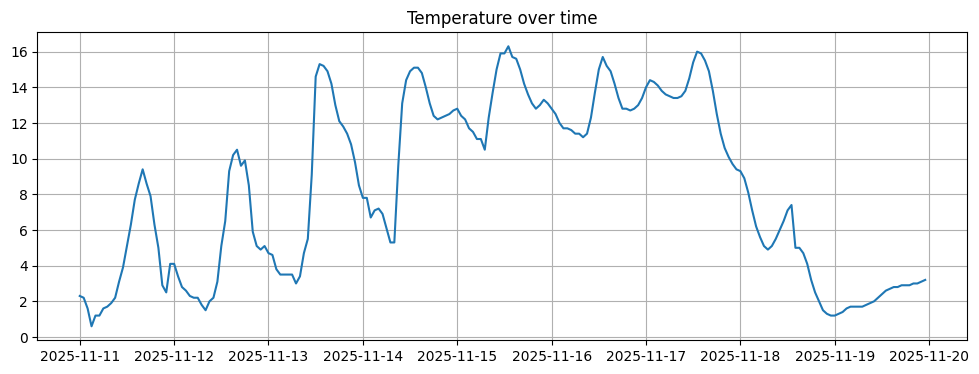

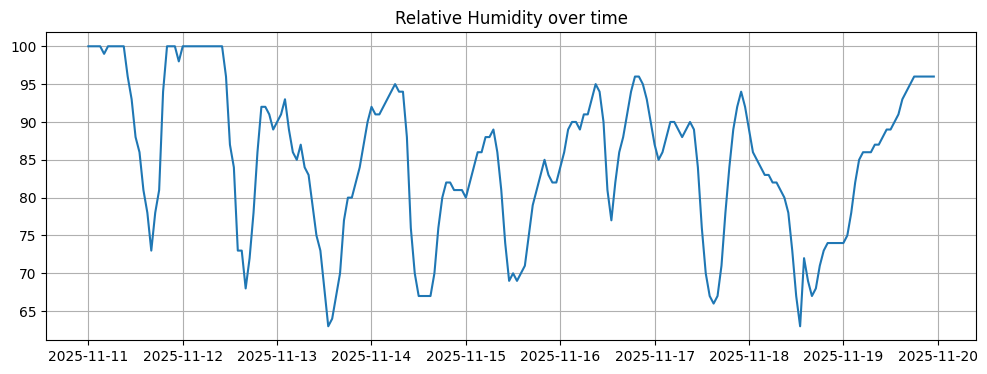

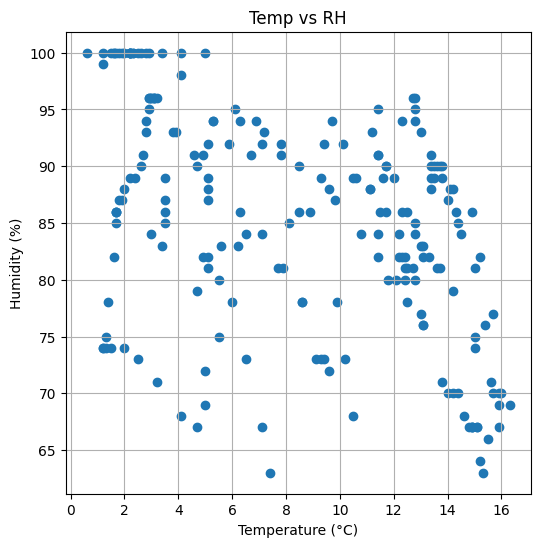

In [166]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(df["time"], df["temp_c"])
plt.title("Temperature over time")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df["time"], df["rh"])
plt.title("Relative Humidity over time")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(df["temp_c"], df["rh"])
plt.xlabel("Temperature (°C)")
plt.ylabel("Humidity (%)")
plt.title("Temp vs RH")
plt.grid(True)
plt.show()


## STEP 4 — Detect anomalies (IsolationForest)

In [167]:
from sklearn.ensemble import IsolationForest

# Model expects numeric features only
X = df[["temp_c", "rh"]]

iso = IsolationForest(contamination=0.05, random_state=42)
df["anomaly"] = iso.fit_predict(X)  # -1 = anomaly, 1 = normal

df["anomaly"].value_counts()



anomaly
 1    205
-1     11
Name: count, dtype: int64

## STEP 5 — Plot anomalies

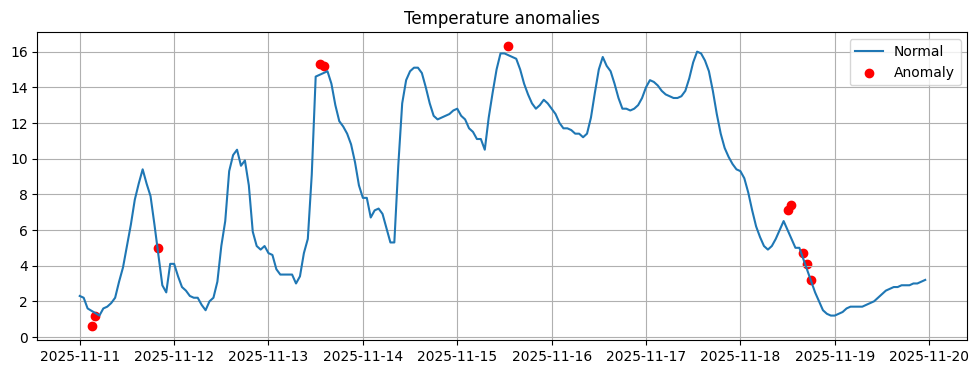

In [168]:
normal = df[df["anomaly"] == 1]
anom = df[df["anomaly"] == -1]

plt.figure(figsize=(12,4))
plt.plot(normal["time"], normal["temp_c"], label="Normal")
plt.scatter(anom["time"], anom["temp_c"], color="red", label="Anomaly")
plt.title("Temperature anomalies")
plt.legend()
plt.grid(True)
plt.show()


## STEP 6 — Export processed dataset
Save final EDA+anomaly dataset to:
📁 data/processed/weather_lju_processed.csv

In [169]:

"""

from pathlib import Path
Path("data/processed").mkdir(parents=True, exist_ok=True)
print("OK -> folder exists!")


processed_f = Path("../data/processed/weather_lju_processed.csv")

processed_f
"""


from pathlib import Path

# Detect repository root (guaranteed correct)
here = Path.cwd()
REPO_ROOT = next(p for p in [here, *here.parents] if (p / ".git").exists())

PROCESSED = REPO_ROOT / "data" / "processed"
PROCESSED.mkdir(parents=True, exist_ok=True)

processed_f = PROCESSED / "weather_lju_processed.csv"
df.to_csv(processed_f, index=False)
processed_f, processed_f.exists(), processed_f.stat().st_size



(WindowsPath('C:/Users/Mihah/PyCharmProjects/data_prototype/data/processed/weather_lju_processed.csv'),
 True,
 9578)

## Exercise 4: EDA + anomaly detection
Load the cleaned weather table into a pandas DataFrame.

## Create a figures folder

In [170]:
from pathlib import Path
import matplotlib.pyplot as plt

# Detect repo root (works from notebooks/)
here = Path.cwd()
REPO_ROOT = next(p for p in [here, *here.parents] if (p / ".git").exists())

FIGURES = REPO_ROOT / "reports" / "figures"
FIGURES.mkdir(parents=True, exist_ok=True)

print("FIGURES dir:", FIGURES)


FIGURES dir: C:\Users\Mihah\PyCharmProjects\data_prototype\reports\figures


## Save a couple of plots

WindowsPath('C:/Users/Mihah/PyCharmProjects/data_prototype/reports/figures/temp_hist.png')

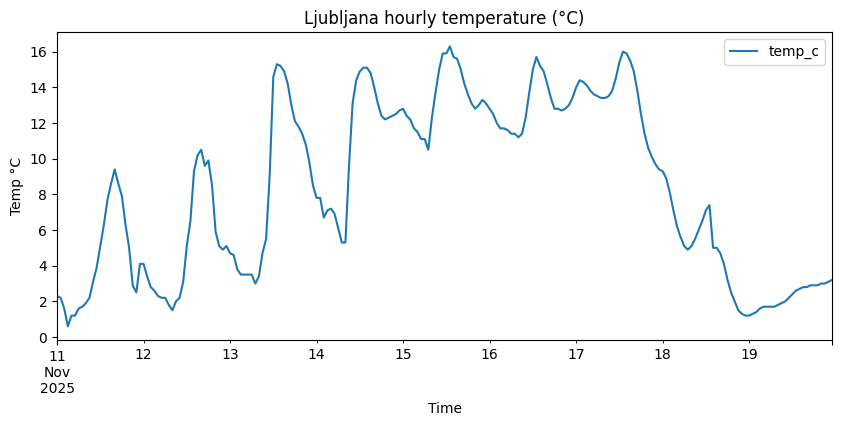

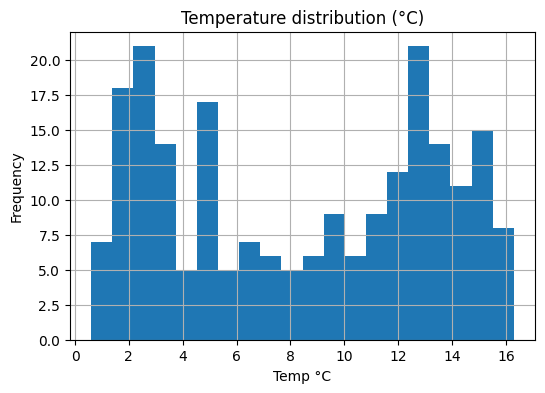

In [171]:
fig, ax = plt.subplots(figsize=(10, 4))
df.plot(x="time", y="temp_c", ax=ax)
ax.set_title("Ljubljana hourly temperature (°C)")
ax.set_xlabel("Time")
ax.set_ylabel("Temp °C")

out_f = FIGURES / "temp_timeseries.png"
fig.savefig(out_f, dpi=150, bbox_inches="tight")
out_f


fig, ax = plt.subplots(figsize=(6, 4))
df["temp_c"].hist(ax=ax, bins=20)
ax.set_title("Temperature distribution (°C)")
ax.set_xlabel("Temp °C")
ax.set_ylabel("Frequency")

out_f = FIGURES / "temp_hist.png"
fig.savefig(out_f, dpi=150, bbox_inches="tight")
out_f

